#  1. Library Imports


In [ ]:
!pip install qiskit qiskit-aer qiskit-machine-learning matplotlib scikit-learn qiskit-algorithms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [ ]:
# Veri İşleme ve Klasik Makine Öğrenimi
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from qiskit_aer import Aer

from qiskit_algorithms.optimizers import COBYLA

from qiskit.primitives import Sampler

from qiskit.circuit.library import ZZFeatureMap, EfficientSU2

from qiskit_machine_learning.algorithms.classifiers import VQC

#  2. Data Preparation

In [ ]:
# Tam Iris veri setini yükle
iris = load_iris()
X, y = iris.data, iris.target

# Özellik Mühendisliği: Daha zor, ikili bir problem oluşturun
# Sadece 1 (versicolor) ve 2 (virginica) sınıflarını kullanacağız çünkü ayırmaları daha zordur.
# Bu, sınıflandırma görevimizi daha ilginç hale getirir.
binary_indices = np.where((y == 1) | (y == 2))
X_binary = X[binary_indices]
y_binary = y[binary_indices]

# İkili sınıflandırıcımız için etiketleri 0 ve 1 olarak yeniden eşle
y_binary[y_binary == 1] = 0
y_binary[y_binary == 2] = 1

In [ ]:
# Ölçekleme
# Özellikleri [0, 1] aralığına ölçeklendirin. Bu, birçok ML algoritması için önemlidir.
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_binary)

In [ ]:
# PCA ile Boyut Azaltma
# ÖNEMLİ: Mevcut kuantum bilgisayarlar (ve simülatörler) birçok özelliği (kubit) işleyemez.
# 4 özelliğimizi 2'ye düşürmek için Temel Bileşen Analizi (PCA) kullanacağız.
# Bu, KML'de ÇOK yaygın ve gerekli bir adımdır.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
# Eğitim-Test Bölme
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_binary, test_size=0.3, random_state=42, stratify=y_binary)

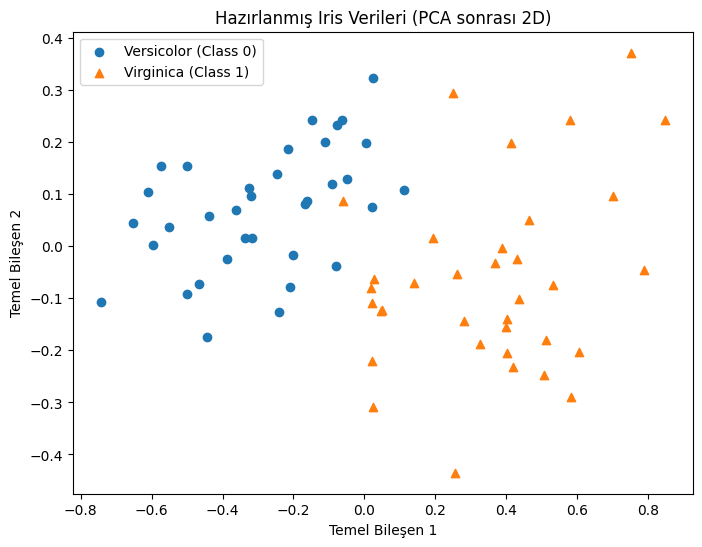

In [ ]:
# Hazırladığımız verileri ne üzerinde çalıştığımızı görmek için görselleştirelim
plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], marker='o', label='Versicolor (Class 0)')
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], marker='^', label='Virginica (Class 1)')
plt.title("Hazırlanmış Iris Verileri (PCA sonrası 2D)")
plt.xlabel("Temel Bileşen 1")
plt.ylabel("Temel Bileşen 2")
plt.legend()
plt.show()

#  3. Building the VQC Components

In [ ]:
# Özellik sayısı ihtiyacımız olan kubit sayısına eşittir
num_qubits = X_train.shape[1] # PCA nedeniyle bu 2 olacaktır

# Adım 3.1: Özellik Haritası
# Bu devre, klasik verilerimizi kuantum durum uzayına kodlar.
# Standart bir seçim olan ZZFeatureMap'i kullanacağız. 'reps', desenin kaç kez tekrarlandığını belirtir.
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2)
print("--- Özellik Haritası Devresi ---")
print(feature_map.decompose().draw())

--- Özellik Haritası Devresi ---
     ┌───┐┌─────────────┐                                          ┌───┐»
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└─────────────┘└───┘└──────────────────────────────┘└───┘└───┘»
«     ┌─────────────┐                                          
«q_0: ┤ P(2.0*x[0]) ├──■────────────────────────────────────■──
«     ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐
«q_1: ┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └─────────────┘└───┘└──────────────────────────────┘└───┘


In [ ]:
# Adım 3.2: Ansatz (Parametrelenmiş Kuantum Devresi)
# Bu, sinir ağlarındaki katmanlar gibi kuantum devremizin "eğitilebilir" kısmıdır.
# EfficientSU2 esnek ve güçlü bir ansatztır.
ansatz = EfficientSU2(num_qubits=num_qubits, reps=2)
print("\n--- Ansatz (Eğitilebilir) Devre ---")
print(ansatz.decompose().draw())


--- Ansatz (Eğitilebilir) Devre ---
     ┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐     ┌──────────┐»
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[2]) ├──■──┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├──■──┤ Ry(θ[8]) ├»
     ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤┌─┴─┐├──────────┤»
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[3]) ├┤ X ├┤ Ry(θ[5]) ├┤ Rz(θ[7]) ├┤ X ├┤ Ry(θ[9]) ├»
     └──────────┘└──────────┘└───┘└──────────┘└──────────┘└───┘└──────────┘»
«     ┌───────────┐
«q_0: ┤ Rz(θ[10]) ├
«     ├───────────┤
«q_1: ┤ Rz(θ[11]) ├
«     └───────────┘


In [ ]:
# Adım 3.3: Optimize Edici
# VQC hibrit bir algoritmadır. Kuantum ansatz'ımızın parametrelerini güncellemek için klasik bir optimize ediciye ihtiyaç vardır.
# COBYLA simülasyon için iyi bir seçimdir. # maxiter = maksimum optimizasyon adımı sayısı
optimizer = COBYLA(maxiter=100)

In [ ]:
# Adım 3.4: Geri Çağırma Fonksiyonu (görselleştirme için)
# Bu fonksiyon optimizasyonun her adımında çağrılacaktır
# böylece eğitim sırasında maliyet fonksiyonunun nasıl azaldığını görebiliriz.
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_val):
    objective_func_vals.append(obj_func_val)
    print(f"İterasyon {len(objective_func_vals)}: Maliyet = {obj_func_val:.4f}")

In [ ]:
# Adım 3.5: VQC'yi Birleştirme
# Şimdi tüm parçaları VQC modelinde birleştiriyoruz.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
    sampler=Sampler() # quantum_instance yerine Sampler kullanın
)

/tmp/ipython-input-1824403607.py:8: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler=Sampler() # quantum_instance yerine Sampler kullanın


#  4. Training and Evaluation



 ***** VQC Eğitimi Başlıyor ***** 


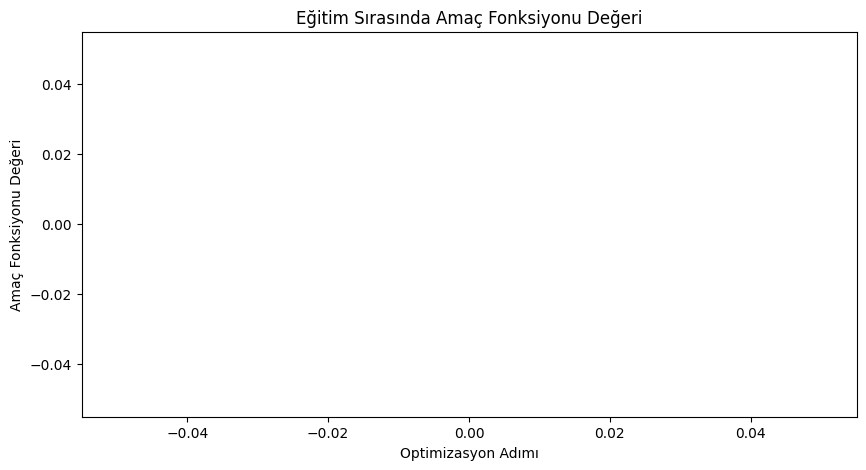

In [ ]:
print("\n ***** VQC Eğitimi Başlıyor ***** ")
vqc.fit(X_train, y_train)

# Eğitim ilerlemesini çizdir
plt.figure(figsize=(10, 5))
plt.title("Eğitim Sırasında Amaç Fonksiyonu Değeri")
plt.xlabel("Optimizasyon Adımı")
plt.ylabel("Amaç Fonksiyonu Değeri")
plt.plot(range(len(objective_func_vals)), objective_func_vals)
plt.show()

In [ ]:
# VQC modelini test setinde değerlendir
y_pred_vqc = vqc.predict(X_test)
vqc_accuracy = accuracy_score(y_test, y_pred_vqc)
print(f"\n--- VQC Model Değerlendirmesi ---")
print(f"Kuantum Model (VQC) Doğruluğu: {vqc_accuracy:.4f}")

# Karşılaştırma için, aynı PCA azaltılmış veriler üzerinde klasik bir SVM eğitelim
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\n--- Klasik SVM Model Değerlendirmesi (karşılaştırma için) ---")
print(f"Aynı veriler üzerinde Klasik Model (SVM) Doğruluğu: {svm_accuracy:.4f}")


--- VQC Model Değerlendirmesi ---
Kuantum Model (VQC) Doğruluğu: 0.7000

--- Klasik SVM Model Değerlendirmesi (karşılaştırma için) ---
Aynı veriler üzerinde Klasik Model (SVM) Doğruluğu: 0.8667


Projeyi devam ettirmek isterseniz, işte bazı olası adımlar:

*   **Farklı Veri Setleri Denemek:** Iris veri setinin farklı alt kümelerini veya tamamen farklı veri setlerini kullanarak VQC modelinin performansını test edebilirsiniz.
*   **Farklı Özellik Haritaları ve Ansatzlar Kullanmak:** Qiskit'te bulunan diğer özellik haritalarını (örneğin, PauliFeatureMap) ve ansatzları (örneğin, RealAmplitudes) deneyerek modelin etkinliğini karşılaştırabilirsiniz.
*   **Optimize Ediciyi Ayarlamak:** COBYLA dışındaki optimize edicileri (örneğin, SPSA) deneyebilir ve optimize edici parametrelerini (örneğin, `maxiter`) farklı değerlerle ayarlayarak eğitim sürecini iyileştirebilirsiniz.
*   **Daha Fazla Kubit Kullanmak:** Daha fazla özelliği dahil etmek için (PCA olmadan veya daha fazla bileşenle) veya daha karmaşık devreler oluşturmak için daha fazla kubit kullanmayı deneyebilirsiniz. Bunun için daha güçlü simülatörlere veya gerçek kuantum donanımına erişim gerekebilir.
*   **Diğer Kuantum Makine Öğrenimi Algoritmalarını Keşfetmek:** Kuantum Destek Vektör Makineleri (QSVM) veya Kuantum Nöral Ağlar (QNN) gibi Qiskit Machine Learning kütüphanesindeki diğer algoritmaları inceleyebilirsiniz.
*   **Hiperparametre Optimizasyonu:** Klasik makine öğreniminde olduğu gibi, VQC modelinin hiperparametrelerini (özellik haritası ve ansatz'ın katman sayısı gibi) optimize etmek için teknikler uygulayabilirsiniz.
*   **Sonuçları Daha Detaylı Analiz Etmek:** Doğruluk dışında, kesinlik, geri çağırma, F1 puanı ve karışıklık matrisi gibi diğer metrikleri kullanarak modelin performansını daha derinlemesine analiz edebilirsiniz.
*   **Gerçek Kuantum Donanımında Çalıştırmak:** Simülatörler yerine IBM Quantum Experience gibi platformlardaki gerçek kuantum donanımlarında modelinizi çalıştırmayı deneyebilirsiniz. Bu, kuantum donanımının mevcut sınırlamalarını ve gürültüyü anlamak için önemlidir.